In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import utilsfunc as uf
from sklearn.impute import KNNImputer, SimpleImputer

In [2]:
df = pd.read_csv("training_set_features.csv", index_col="respondent_id")
mappings = uf.read_json("mapping.json")
results = pd.read_csv("training_set_labels.csv", index_col="respondent_id")
df = pd.concat([df, results], axis=1)

In [3]:
df_labeled = df.copy()

for col, mapping in mappings.items():
    df_labeled[col] = df_labeled[col].map(mapping)

In [4]:
threshold = 0.2
for col in df_labeled.columns:
    if df_labeled[col].isna().sum()/len(df_labeled)>threshold:
        print(f"More than {threshold:.0%} in {col} are missing ({df_labeled[col].isna().sum()/len(df_labeled):.02%})")

More than 20% in health_insurance are missing (45.96%)
More than 20% in employment_industry are missing (49.91%)
More than 20% in employment_occupation are missing (50.44%)


In [5]:
threshold = 0.2
test = df_labeled.copy()
for col in test.columns:
    if test[col].isna().sum()/len(test)>threshold:
        test.drop(columns=col, inplace=True)

In [6]:
test.drop(["hhs_geo_region"], axis=1, inplace=True)

In [7]:
knn_imputer = KNNImputer(
    n_neighbors=5, 
    weights="uniform",
    metric="nan_euclidean",
    )
cleaned_df = pd.DataFrame(knn_imputer.fit_transform(test), columns=test.columns)

In [8]:
simple_imputer = SimpleImputer(strategy="most_frequent")
cleaned_df = pd.DataFrame(simple_imputer.fit_transform(test), columns=test.columns)

In [9]:
# Checking binary columns 
binary_cols = [col for col in cleaned_df.columns if cleaned_df[col].nunique() == 2]
non_binary_cols = [col for col in cleaned_df.columns if cleaned_df[col].nunique() != 2]

for col in cleaned_df.columns:
    cont = pd.crosstab(cleaned_df[col], cleaned_df["h1n1_vaccine"])
    chi2, p, dof, expected = chi2_contingency(cont)
    print(f"P-value for {col} vs h1n1_vaccine: {p:.5f}")

P-value for h1n1_concern vs h1n1_vaccine: 0.00000
P-value for h1n1_knowledge vs h1n1_vaccine: 0.00000
P-value for behavioral_antiviral_meds vs h1n1_vaccine: 0.00000
P-value for behavioral_avoidance vs h1n1_vaccine: 0.00000
P-value for behavioral_face_mask vs h1n1_vaccine: 0.00000
P-value for behavioral_wash_hands vs h1n1_vaccine: 0.00000
P-value for behavioral_large_gatherings vs h1n1_vaccine: 0.00328
P-value for behavioral_outside_home vs h1n1_vaccine: 0.00033
P-value for behavioral_touch_face vs h1n1_vaccine: 0.00000
P-value for doctor_recc_h1n1 vs h1n1_vaccine: 0.00000
P-value for doctor_recc_seasonal vs h1n1_vaccine: 0.00000
P-value for chronic_med_condition vs h1n1_vaccine: 0.00000
P-value for child_under_6_months vs h1n1_vaccine: 0.00000
P-value for health_worker vs h1n1_vaccine: 0.00000
P-value for opinion_h1n1_vacc_effective vs h1n1_vaccine: 0.00000
P-value for opinion_h1n1_risk vs h1n1_vaccine: 0.00000
P-value for opinion_h1n1_sick_from_vacc vs h1n1_vaccine: 0.00000
P-value fo

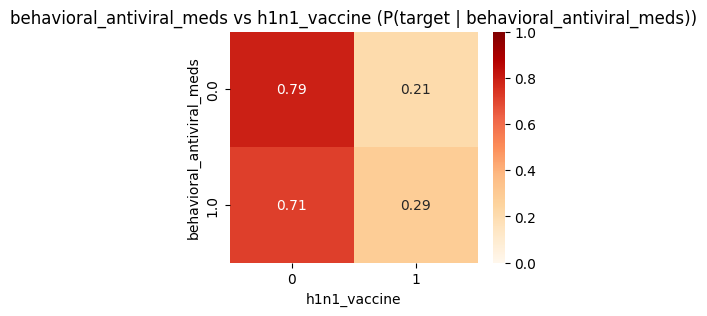

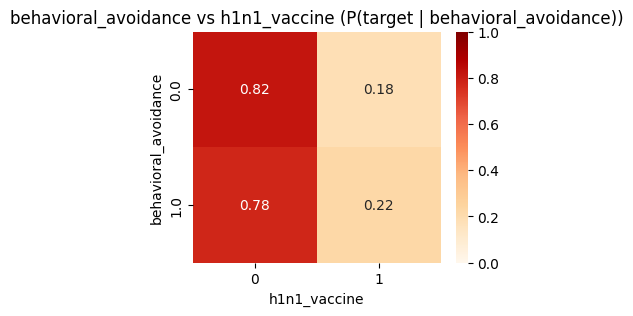

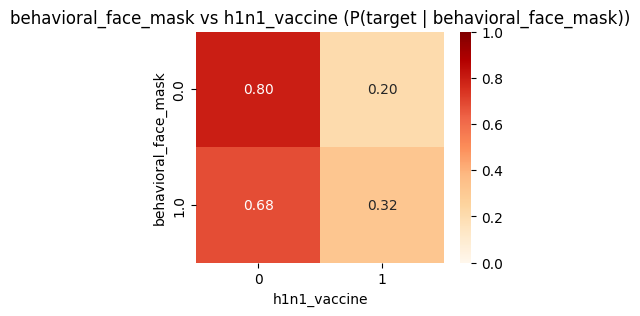

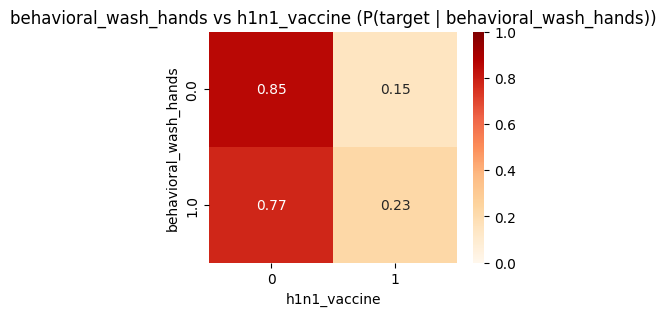

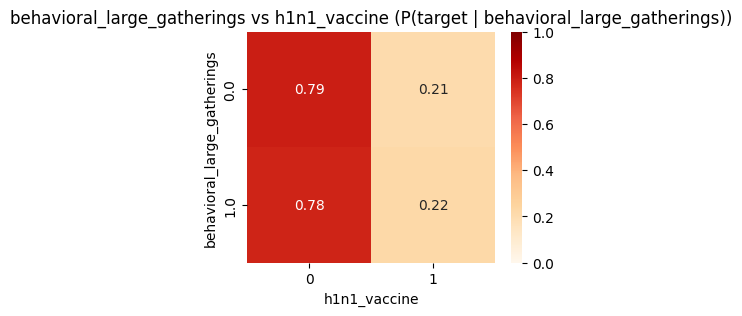

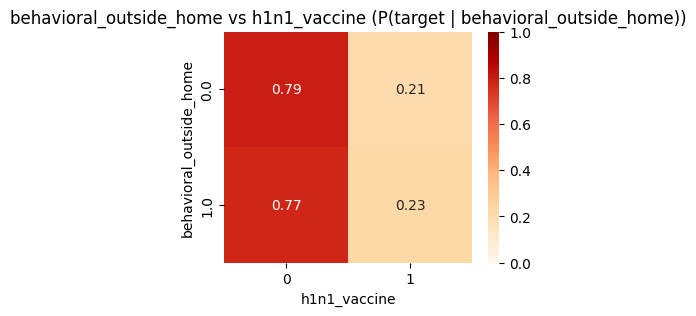

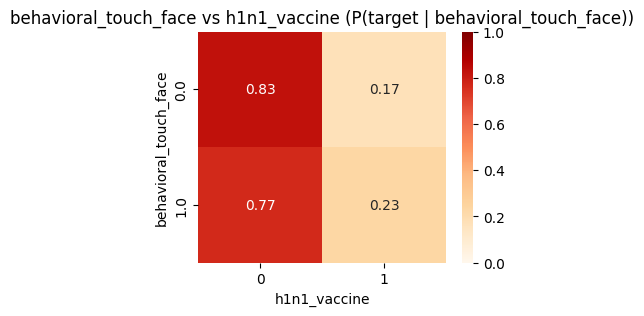

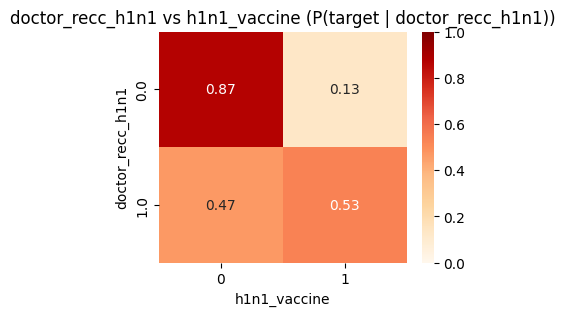

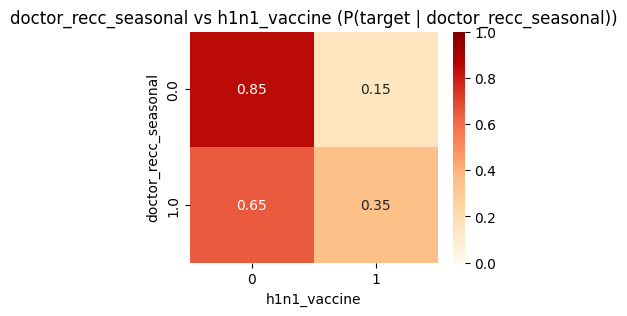

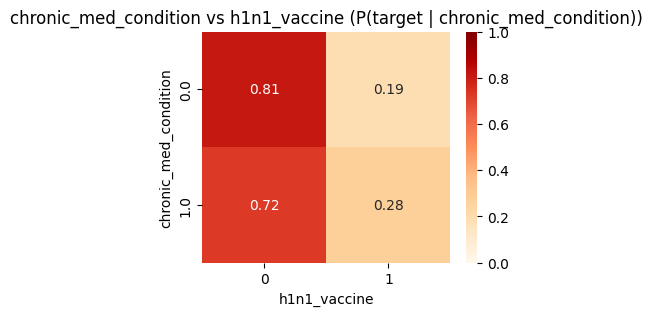

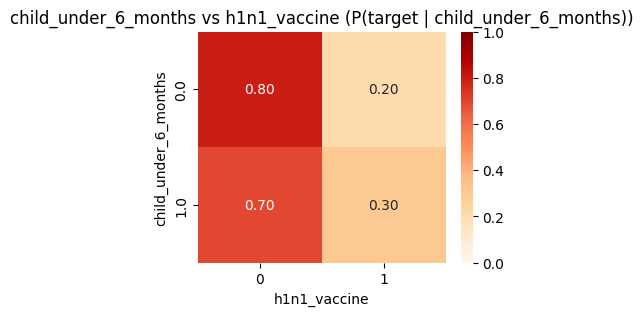

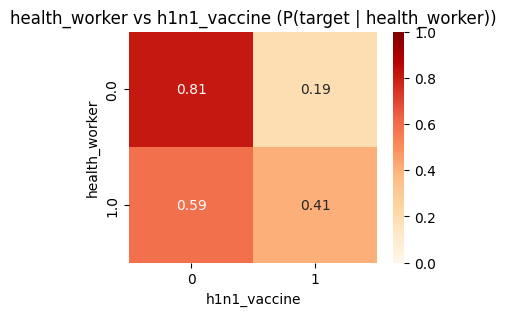

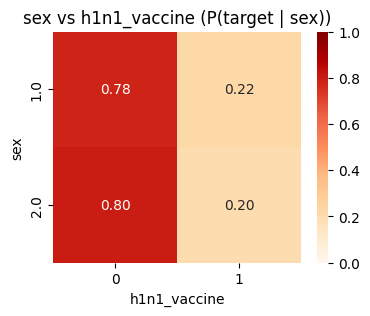

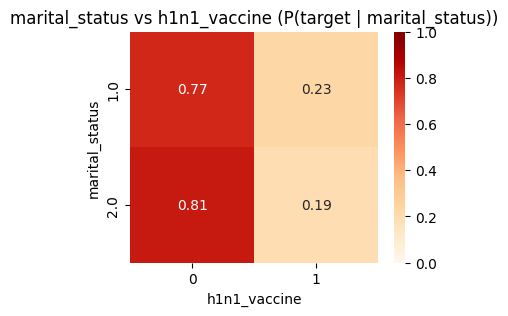

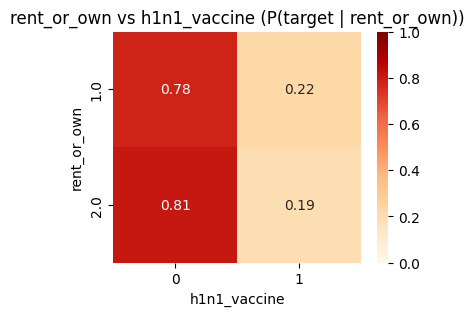

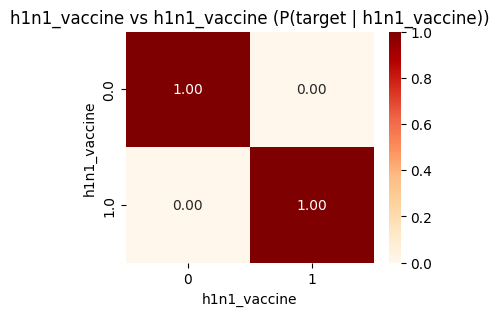

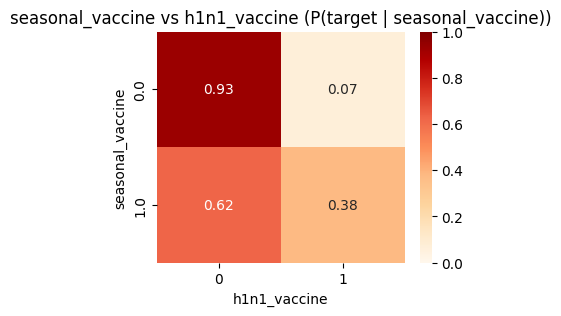

In [10]:
target = "h1n1_vaccine"

for col in binary_cols:
    plt.figure(figsize=(4,3))

    cont = pd.crosstab(cleaned_df[col], results[target], normalize="index")

    sns.heatmap(cont, annot=True, fmt=".2f", cmap="OrRd",
                vmin=0, vmax=1)
    plt.title(f"{col} vs {target} (P(target | {col}))")
    plt.xlabel(target)
    plt.ylabel(col)
    plt.show()

In [11]:
drop_variables = [
    "behavioral_large_gatherings",
    "sex",
    "behavioral_outside_home",
    "census_msa",
    "household_children"
    ]

In [12]:
cleaned_df.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'census_msa', 'household_adults',
       'household_children', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='str')

In [13]:
cleaned_df.drop(columns=drop_variables, inplace=True)
cleaned_df.to_csv("cleaned_data.csv", index=False)